In [138]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, Bidirectional, Embedding, LSTM

In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [47]:
df['sentiment'] = df.sentiment.map({'positive':1, 'negative':0})

In [12]:
def process_text(text):
    text=text.lower()
    text=re.sub("<br ?/?>", " ", text)
    text=re.sub("[^\w\s]", " ", text)
    return text

In [13]:
df['review']=df['review'].apply(process_text)

In [44]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def lang_process(text):
    tokens = [word for word in word_tokenize(text) if word not in stop_words]
    stems = [wnl.lemmatize(word, pos='v') for word in tokens]
    st=" ".join(stems)
    
        
    return st

[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     No connection could be made because the target machine
[nltk_data]     actively refused it>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10061] No
[nltk_data]     connection could be made because the target machine
[nltk_data]     actively refused it>
[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [46]:
df['cleaned_review'] = df.review.apply(lang_process)

In [50]:
X=df['cleaned_review']
y=df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [52]:
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
padding_type='post'
trunc_type='post'

In [53]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [54]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [61]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 389,425
Trainable params: 389,425
Non-trainable params: 0
__________________________________________________

In [62]:
history = model.fit(train_padded, y_train,
                    epochs=10, verbose=1,
                    validation_split=0.15
                   )

Epoch 1/10


C:\Users\ishan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


997/997 [==============================] - 133s 130ms/step - loss: 0.4042 - accuracy: 0.8219 - val_loss: 0.3127 - val_accuracy: 0.8677
Epoch 2/10
997/997 [==============================] - 122s 123ms/step - loss: 0.2848 - accuracy: 0.8858 - val_loss: 0.3228 - val_accuracy: 0.8697
Epoch 3/10
997/997 [==============================] - 144s 145ms/step - loss: 0.2502 - accuracy: 0.9016 - val_loss: 0.2967 - val_accuracy: 0.8738
Epoch 4/10
997/997 [==============================] - 134s 134ms/step - loss: 0.2136 - accuracy: 0.9184 - val_loss: 0.3230 - val_accuracy: 0.8768
Epoch 5/10
997/997 [==============================] - 128s 128ms/step - loss: 0.1813 - accuracy: 0.9313 - val_loss: 0.3840 - val_accuracy: 0.8709
Epoch 6/10
997/997 [==============================] - 129s 130ms/step - loss: 0.1609 - accuracy: 0.9423 - val_loss: 0.3733 - val_accuracy: 0.8665
Epoch 7/10
997/997 [==============================] - 137s 138ms/step - loss: 0.1404 - accuracy: 0.9501 - val_loss: 0.4298 - val_accura

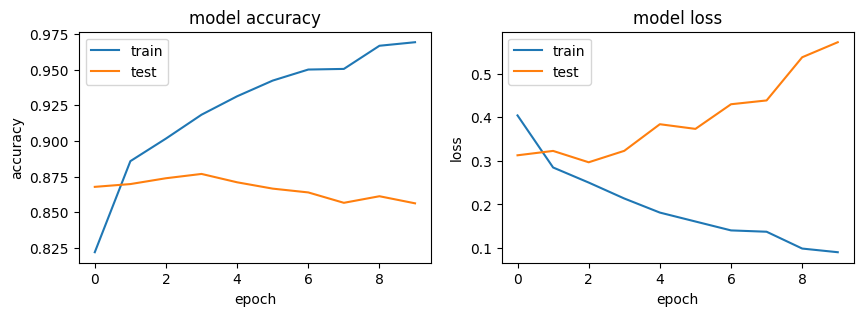

In [78]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
predictions = model.predict(test_padded)

y_pred=[1 if i > 0.5 else 0 for i in predictions]

391/391 [==============================] - 12s 31ms/step


In [142]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      6923
           1       0.81      0.90      0.85      5577

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.87      0.86      0.86     12500



In [143]:
print(confusion_matrix(y_pred, y_test))

[[5715 1208]
 [ 535 5042]]


In [133]:
def predict_sentiment(text):
    sentence = [text]
    sequences = tokenizer.texts_to_sequences(sentence)

    padded = pad_sequences(sequences, padding='post', maxlen=max_length)
    
    prediction = model.predict(padded)
    
    pred_labels = []
    for i in prediction:
        if i >= 0.5:
            pred_labels.append(1)
        else:
            pred_labels.append(0)

    senti_labels=[]            
    for i in range(len(sentence)):
        if pred_labels[i] == 1:
            senti_labels.append('Positive')
        else:
            senti_labels.append('Negative')
    
    return senti_labels[0], prediction[0][0]

In [134]:
predict_sentiment("very good film.  done better")

1/1 [==============================] - 0s 31ms/step


('Positive', 0.7326125)

In [112]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [118]:
import io
import json

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))